<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>
Автор материала: Ольга Дайховская (@aiho в Slack ODS)  <br> 

Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала

# <center> Домашнее задание № 4 (демо).
## <center>  Прогнозирование популярности статей на TechMedia (Хабр) с помощью линейных моделей
    
**В задании Вам предлагается разобраться с тем, как работает TfidfVectorizer и DictVectorizer, затем обучить и настроить модель линейной регрессии Ridge на данных о публикациях на Хабрахабре. Пройдя все шаги, вы сможете получить бейзлайн для [соревнования](https://www.kaggle.com/c/howpop-habrahabr-favs-lognorm) (несмотря на old в названии, для этого задания соревнование актуально). 
Ответьте на все вопросы в этой тетрадке и заполните ответы в [гугл-форме](https://docs.google.com/forms/d/1gPt401drm84N2kdezwGWtPJN_JpaFqXoh6IwlWOslb4).**

**Описание соревнования**

Предскажите, как много звездочек наберет статья, зная только ее текст и время публикации

Необходимо предсказать популярность поста на Хабре по содержанию и времени публикации. Как известно, пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать, что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

**Приступим:** импортируем необходимые библиотеки и скачаем данные

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import scipy

%matplotlib inline
from matplotlib import pyplot as plt

Скачайте [данные](https://www.kaggle.com/c/howpop-habrahabr-favs-lognorm/data) соревнования.

In [3]:
train_df = pd.read_csv('https://storage.googleapis.com/kaggle-competitions-data/kaggle/6207/howpop_train.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1530288958&Signature=We%2BFnX1HTwzpMZ3FUTLbluK%2FDUkeA9JKRhEbMnb%2F9f7CyjI%2BzGZoVyAl7MZHmZdYtSEq1pAurm6KnfXNPQhGjvdtCWl%2FqvDEYbEh6sAYO%2F%2FQ5VzGMBlaecx4FmNRd5VGzu9IEYctHZH4BfczpZfK9j5ZiQma89o5cl%2Bc4CFXxRuJky4v31HCBJbHRTsq1kliwK17Pm6PdgzQ1PAsiTOwMFcC2tT4bnvOpI1dok5na8AxEgCJ7VneUFlyxT9QRMC2Kug6AnPPa16hkYB8S%2BTOUY8y78B6gDv5djE6fVp0k%2BOpD0vT4gwMKoZZ7qLyMBSj9jhSnqDhG45hp7IMxgvajA%3D%3D')
test_df  = pd.read_csv('https://storage.googleapis.com/kaggle-competitions-data/kaggle/6207/howpop_test.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1530288832&Signature=cnV%2FwAb0iHuvrMV3uM4Nx%2FYKvEyUhtfoVmzjzaGSpLlV7imtXXfi3NfodsNEkYGFvF92GihU%2BLjt2n8wGxFslsZ4lBwZ7vywic8hA%2BXq0i2hO6MNHwm5o36He9yRWoi6HYogiYgCF9a%2FXGKgl%2FnNkw2fMfaY6X%2FDLkB%2B2uLrPBCvFo2Pvv8yryWs502ixFNCQRQ4zM%2BWWtTAOhAVe4Vy%2B%2FcktA3q2PKZInlnOM8vWjil5TI1WEUD%2B6t%2F3SdQ09Phuxip35AgHXaW0R7%2BSu91QMy5We%2Bxe55dFVAoBwqVVdpprIP8OBd4bEOnGwvCi3Ohb%2FFnCQIAb7b1%2BkFVOMqi%2Fg%3D%3D')

In [4]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [5]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

Убедимся, что данные отсортированы по признаку `published`

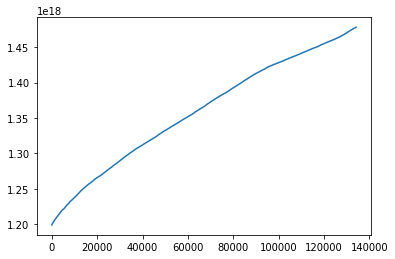

In [6]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

**Чтобы ответить на вопросы 1 и 2, можно использовать [pandas.DataFrame.corr()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html), [pandas.to_datetime()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) и [pandas.Series.value_counts()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html)**

<font color='red'>Вопрос 1.</font> Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)
- да
- нет
- не знаю

In [7]:
train_df.corr(method='pearson')#нет

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,1.000000,0.081628,0.241384,-0.147763,0.089313,0.132385,-0.187885,-0.235594,-0.010376,-0.005845,-0.001605
polling,0.081628,1.000000,-0.003337,0.042605,0.006882,0.025660,-0.033505,0.027116,-0.003523,-0.036385,0.071417
content_len,0.241384,-0.003337,1.000000,-0.023544,0.308194,0.204101,0.068779,-0.078686,0.246063,0.356481,0.073132
comments,-0.147763,0.042605,-0.023544,1.000000,0.164166,0.290035,0.613961,0.457638,0.349568,0.278942,0.662740
favs,0.089313,0.006882,0.308194,0.164166,1.000000,0.634304,0.416241,0.062877,0.456097,0.587982,0.263239
views,0.132385,0.025660,0.204101,0.290035,0.634304,1.000000,0.396849,0.128654,0.585105,0.406782,0.326427
votes_plus,-0.187885,-0.033505,0.068779,0.613961,0.416241,0.396849,1.000000,0.464168,0.414232,0.449712,0.525081
votes_minus,-0.235594,0.027116,-0.078686,0.457638,0.062877,0.128654,0.464168,1.000000,0.146609,0.088226,0.355458
views_lognorm,-0.010376,-0.003523,0.246063,0.349568,0.456097,0.585105,0.414232,0.146609,1.000000,0.688811,0.546530
favs_lognorm,-0.005845,-0.036385,0.356481,0.278942,0.587982,0.406782,0.449712,0.088226,0.688811,1.000000,0.479476


<font color='red'>Вопрос 2.</font> В каком году было больше всего публикаций? (Рассматриваем train_df)
- 2014
- 2015
- 2016
- 2017

In [8]:
from datetime import datetime, date, time
train_df['published'] = pd.to_datetime(train_df['published'])
print(train_df['published'].dt.year.value_counts())
#2015

2015    23452
2016    16316
2014    16180
2012    15972
2013    15537
2011    15063
2010    13091
2009    10783
2008     7743
Name: published, dtype: int64


## Разбиение на train/valid
Используем только признаки 'author', 'flow', 'domain' и 'title'

In [9]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [10]:
len(train_df), train_size

(134137, 93895)

In [11]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.loc[:, features]

In [12]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

## Применение TfidfVectorizer

**TF-IDF** (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции. [Подробнее в источнике](https://ru.wikipedia.org/wiki/TF-IDF)

TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.

**Основные параметры TfidfVectorizer в sklearn:**
- **min_df** - при построении словаря слова, которые встречаются *реже*, чем указанное значение, игнорируются
- **max_df** - при построении словаря слова, которые встречаются *чаще*, чем указанное значение, игнорируются
- **analyzer** - определяет, строятся ли признаки по словам или по символам (буквам)
- **ngram_range** - определяет, формируются ли признаки только из отдельных слов или из нескольких слов (в случае с analyzer='char' задает количество символов). Например, если указать analyzer='word' и ngram_range=(1,3),то признаки будут формироваться из отдельных слов, из пар слов и из троек слов.
- **stop_words** - слова, которые игнорируются при построении матрицы

Более подробно с параметрами можно ознакомиться в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

**Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 3.</font> Какой размер у полученного словаря?
- 43789
- 50624
- 93895
- 74378

In [13]:
vectorizer_title = TfidfVectorizer( min_df=3, max_df=0.3,ngram_range=(1, 3))

X_train_title = vectorizer_title.fit_transform(X_train['title'])
X_valid_title = vectorizer_title.transform(X_valid['title'])
X_test_title = vectorizer_title.transform(X_test['title'])

In [14]:
len(vectorizer_title.vocabulary_)#размер словаря

50624

<font color='red'>Вопрос 4.</font> Какой индекс у слова 'python'?
- 1
- 10
- 9065
- 15679

In [15]:
vectorizer_title.vocabulary_['python']

9065

**Инициализируйте TfidfVectorizer, указав analyzer='char'.<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 5.</font> Какой размер у полученного словаря?
- 218
- 510
- 125
- 981

In [35]:
vectorizer_title_ch = TfidfVectorizer(analyzer='char')

X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
X_test_title_ch = vectorizer_title_ch.transform(X_test['title'])

In [36]:
# Здесь так же можно посмотреть словарь
# Заметьте насколько отличаются словари для TfidfVectorizer с analyzer='word' и analyzer='char'
vectorizer_title_ch.vocabulary_

{u' ': 0,
 u'!': 1,
 u'"': 2,
 u'#': 3,
 u'$': 4,
 u'%': 5,
 u'&': 6,
 u"'": 7,
 u'(': 8,
 u')': 9,
 u'*': 10,
 u'+': 11,
 u',': 12,
 u'-': 13,
 u'.': 14,
 u'/': 15,
 u'0': 16,
 u'1': 17,
 u'2': 18,
 u'3': 19,
 u'4': 20,
 u'5': 21,
 u'6': 22,
 u'7': 23,
 u'8': 24,
 u'9': 25,
 u':': 26,
 u';': 27,
 u'<': 28,
 u'=': 29,
 u'>': 30,
 u'?': 31,
 u'@': 32,
 u'[': 33,
 u'\\': 34,
 u']': 35,
 u'^': 36,
 u'_': 37,
 u'`': 38,
 u'a': 39,
 u'b': 40,
 u'c': 41,
 u'd': 42,
 u'e': 43,
 u'f': 44,
 u'g': 45,
 u'h': 46,
 u'i': 47,
 u'j': 48,
 u'k': 49,
 u'l': 50,
 u'm': 51,
 u'n': 52,
 u'o': 53,
 u'p': 54,
 u'q': 55,
 u'r': 56,
 u's': 57,
 u't': 58,
 u'u': 59,
 u'v': 60,
 u'w': 61,
 u'x': 62,
 u'y': 63,
 u'z': 64,
 u'{': 65,
 u'|': 66,
 u'}': 67,
 u'~': 68,
 u'\x92': 69,
 u'\x97': 70,
 u'\xa0': 71,
 u'\xa3': 72,
 u'\xa5': 73,
 u'\xa7': 74,
 u'\xa9': 75,
 u'\xab': 76,
 u'\xad': 77,
 u'\xae': 78,
 u'\xb0': 79,
 u'\xb1': 80,
 u'\xb2': 81,
 u'\xb5': 82,
 u'\xb7': 83,
 u'\xb9': 84,
 u'\xbb': 85,
 u'\xbc': 86

In [19]:
len(vectorizer_title_ch.vocabulary_)# размер ch словаря

218

## Работа с категориальными признаками

Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать DictVectorizer из sklearn.

In [20]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


Рассмотрим как он работает на примере первых пяти строк

In [21]:
# сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [22]:
# Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
# а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 1: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 2: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 3: {'author': '@Taoorus', 'domain': 'habrahabr.ru', 'flow': 'design'},
 4: {'author': '@dennydo', 'domain': 'geektimes.ru', 'flow': '-'},
 5: {'author': '@lvea', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 6: {'author': '@abbasov', 'domain': 'geektimes.ru', 'flow': '-'},
 7: {'author': '@Andrey', 'domain': 'habrahabr.ru', 'flow': 'misc'},
 8: {'author': '@kvladimir', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 9: {'author': '@lvea', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 10: {'author': '@caxep', 'domain': 'geektimes.ru', 'flow': '-'},
 11: {'author': '@clops', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 12: {'author': '@vasilyyaremchuk',
  'domain': 'habrahabr.ru',
  'flow': 'management'},
 13: {'author': '@suckdontbite', 'domain': 'geektimes.ru', 'flow

In [23]:
# В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
# поэтому используем .values()
X_train[feats].fillna('-').T.to_dict().values()

[{'author': '@Tapac', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 {'author': '@Taoorus', 'domain': 'habrahabr.ru', 'flow': 'design'},
 {'author': '@dennydo', 'domain': 'geektimes.ru', 'flow': '-'},
 {'author': '@lvea', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 {'author': '@abbasov', 'domain': 'geektimes.ru', 'flow': '-'},
 {'author': '@Andrey', 'domain': 'habrahabr.ru', 'flow': 'misc'},
 {'author': '@kvladimir', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 {'author': '@lvea', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 {'author': '@caxep', 'domain': 'geektimes.ru', 'flow': '-'},
 {'author': '@clops', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 {'author': '@vasilyyaremchuk',
  'domain': 'habrahabr.ru',
  'flow': 'management'},
 {'author': '@suckdontbite', 'domain': 'geektimes.ru', 'flow': '-'},
 {'author': '@blv', 'domain': 'habrah

In [24]:
# В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats].fillna('-').T.to_dict().values())
dict_vect_matrix

<93895x17869 sparse matrix of type '<type 'numpy.float64'>'
	with 281685 stored elements in Compressed Sparse Row format>

In [25]:
# Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
# В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
# Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(93895, 17869)

Посмотрим сколько уникальных значений в каждой колонке.<br />
Суммарно их 9 - столько же, сколько и колонок. Это объясняется тем, что для категориальных признаков со строковыми значениями DictVectorizer делает кодирование бинарными признаками - каждому уникальному значению признака соответствует один новый бинарный признак, который равен 1 только в том случае, если в исходной матрице этот признак принимает значение, которому соответствует эта колонка новой матрицы.

In [27]:
for col in feats:
    print(col,len(X_train[col].fillna('-').unique()))

('author', 17860)
('flow', 7)
('domain', 2)


Также можно посмотреть что означает каждая колонка полученной матрицы

In [28]:
# например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=-',
 'author=@0000168',
 'author=@01000110110010010010',
 'author=@03uk',
 'author=@047',
 'author=@069056',
 'author=@0dd_b1t',
 'author=@0decca',
 'author=@0dmin',
 'author=@0leGG',
 'author=@0lgaShulgina',
 'author=@0lorin',
 'author=@0n1x',
 'author=@0n1y_0ne',
 'author=@0nly0ne',
 'author=@0range',
 'author=@0serd0',
 'author=@0serg',
 'author=@0ver',
 'author=@0x0FFF',
 'author=@0x3f00',
 'author=@0x62ash',
 'author=@0x656b694d',
 'author=@0xA0',
 'author=@0xBA0BAB',
 'author=@0xFE',
 'author=@0xd34df00d',
 'author=@0xy',
 'author=@0zon',
 'author=@100chuk',
 'author=@100xkg',
 'author=@1010101001000100110100111',
 'author=@1024',
 'author=@1099511627776',
 'author=@10s',
 'author=@1101_debian',
 'author=@11101010',
 'author=@1111paha1111',
 'author=@1337',
 'author=@13alex',
 'author=@13i',
 'author=@13oz',
 'author=@14TBAP_Kos',
 'author=@14zy',
 'author=@150Rus',
 'author=@1602',
 'author=@1976an',
 'author=@1999',
 'author=@19N4T0V',
 'author=@1KoT1',
 'author=@1Padr

**Инициализируйте DictVectorizer с параметрами по умолчанию.<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

In [29]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train.loc[:, feats].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid.loc[:, feats].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test.loc[:, feats].fillna('-').T.to_dict().values())

In [30]:
X_train_feats.shape

(93895, 17869)

Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [33]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

## Обучение модели

Далее будем использовать Ridge, линейную модель с l2-регуляризацией.
[Документация](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

Основной параметр Ridge - **alpha, коэффициент регуляризации**. Регуляризация используется для улучшения обобщающей способности модели - прибавляя к функционалу потерь сумму квадратов весов, умноженную на коэффициент регуляризации (та самая alpha), мы штрафуем модель за слишком большие значения весов и не позволяем ей переобучаться. Чем больше этот коээфициент, тем сильнее эффект.

**Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1**

**Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.**

<font color='red'>Вопрос 6.</font> Выберите верные утверждения:
- обе модели показывают одинаковый результат (среднеквадратичная ошибка отличается не больше чем на тысячные), регуляризация ничего не меняет
- при alpha=0.1 модель переобучается
- среднеквадратичная ошибка первой модели на тесте меньше
- при alpha=1.0 у модели обощающая способность лучше, чем у при alpha=0.1

In [37]:
%%time
model1 = Ridge(alpha=0.1, random_state = 1)
model1.fit(X_train, y_train)
model2 = Ridge(alpha=1.0, random_state = 1) 
model2.fit(X_train, y_train)

ValueError: could not convert string to float: Yii 1.1.16

In [107]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds1))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds1))

NameError: name 'X_train_new' is not defined

In [ ]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds2))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds2))

## Baseline

**Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.**

In [38]:
%%time

model = Ridge()
#обучаем на всех данных
model.fit(scipy.sparse.vstack([X_train_new, X_valid_new]), y) 
test_preds = model.predict(X_test_new)

CPU times: user 9.37 s, sys: 231 ms, total: 9.6 s
Wall time: 9.68 s


In [39]:
sample_submission = pd.read_csv('../../data/habr_sample_submission.csv', 
                                index_col='url')

In [40]:
sample_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754


In [41]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds
# это будет бейзлайн "Простое решение"
ridge_submission.to_csv('ridge_baseline.csv') 